# Pre-trained model transfer learning for application in the specific dataset scenario

## Importing libraries and loading the dataset

In [26]:
import sys
import cv2
import time
import colorsys
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!unzip /content/128x128_acc_0.9549_loss_0.0886_val-acc_0.9554_val-loss_0.0873_0.22M_01-08-21-DB_UCB300_E_10x1E-4_5x1E-5-20220906T151844Z-001.zip

Archive:  /content/128x128_acc_0.9549_loss_0.0886_val-acc_0.9554_val-loss_0.0873_0.22M_01-08-21-DB_UCB300_E_10x1E-4_5x1E-5-20220906T151844Z-001.zip
   creating: 128x128_acc_0.9549_loss_0.0886_val-acc_0.9554_val-loss_0.0873_0.22M_01-08-21-DB_UCB300_E_10x1E-4_5x1E-5/assets/
  inflating: 128x128_acc_0.9549_loss_0.0886_val-acc_0.9554_val-loss_0.0873_0.22M_01-08-21-DB_UCB300_E_10x1E-4_5x1E-5/saved_model.pb  
  inflating: 128x128_acc_0.9549_loss_0.0886_val-acc_0.9554_val-loss_0.0873_0.22M_01-08-21-DB_UCB300_E_10x1E-4_5x1E-5/variables/variables.index  
  inflating: 128x128_acc_0.9549_loss_0.0886_val-acc_0.9554_val-loss_0.0873_0.22M_01-08-21-DB_UCB300_E_10x1E-4_5x1E-5/keras_metadata.pb  
  inflating: 128x128_acc_0.9549_loss_0.0886_val-acc_0.9554_val-loss_0.0873_0.22M_01-08-21-DB_UCB300_E_10x1E-4_5x1E-5/variables/variables.data-00000-of-00001  


In [43]:
!unzip /content/128x128_acc_0.9471_loss_0.0605_val-acc_0.9476_val-loss_0.0586_0.22M_29-07-21-DB-best-20220826T211338Z-001.zip

Archive:  /content/128x128_acc_0.9471_loss_0.0605_val-acc_0.9476_val-loss_0.0586_0.22M_29-07-21-DB-best-20220826T211338Z-001.zip
   creating: 128x128_acc_0.9471_loss_0.0605_val-acc_0.9476_val-loss_0.0586_0.22M_29-07-21-DB-best/assets/
  inflating: 128x128_acc_0.9471_loss_0.0605_val-acc_0.9476_val-loss_0.0586_0.22M_29-07-21-DB-best/keras_metadata.pb  
  inflating: 128x128_acc_0.9471_loss_0.0605_val-acc_0.9476_val-loss_0.0586_0.22M_29-07-21-DB-best/saved_model.pb  
  inflating: 128x128_acc_0.9471_loss_0.0605_val-acc_0.9476_val-loss_0.0586_0.22M_29-07-21-DB-best/variables/variables.index  
  inflating: 128x128_acc_0.9471_loss_0.0605_val-acc_0.9476_val-loss_0.0586_0.22M_29-07-21-DB-best/variables/variables.data-00000-of-00001  


In [28]:
!unzip /content/drive/MyDrive/Segmentation_dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Segmentation_dataset/masked_silhouettes/002-cl-03-019909.jpg  
  inflating: Segmentation_dataset/masked_silhouettes/002-cl-03-019911.jpg  
  inflating: Segmentation_dataset/masked_silhouettes/002-cl-04-019926.jpg  
  inflating: Segmentation_dataset/masked_silhouettes/002-cl-04-019954.jpg  
  inflating: Segmentation_dataset/masked_silhouettes/002-cl-05-020006.jpg  
  inflating: Segmentation_dataset/masked_silhouettes/003-nm-02-020081.jpg  
  inflating: Segmentation_dataset/masked_silhouettes/003-nm-02-020102.jpg  
  inflating: Segmentation_dataset/masked_silhouettes/003-nm-02-020121.jpg  
  inflating: Segmentation_dataset/masked_silhouettes/003-nm-02-020135.jpg  
  inflating: Segmentation_dataset/masked_silhouettes/003-nm-03-020193.jpg  
  inflating: Segmentation_dataset/masked_silhouettes/003-nm-04-020257.jpg  
  inflating: Segmentation_dataset/masked_silhouettes/003-nm-04-020272.jpg  
  inflating: Segmentation_dataset/mas

In [50]:
!mkdir rgb
!mkdir masks

!mv /content/Segmentation_dataset/rgb_silhouettes /content/rgb 
!mv /content/Segmentation_dataset/masked_silhouettes /content/masks

In [71]:
data_generator = ImageDataGenerator(rescale=1/255,
                                    validation_split=0.1)       

In [72]:
img_sil = "/content/rgb"
masked_sil = "/content/masks"

batch = 256

train_images_generator = data_generator.flow_from_directory(
                                        directory=img_sil,
                                        target_size=(128, 128),
                                        batch_size=batch,
                                        class_mode=None,
                                        classes=None,
                                        color_mode = 'rgb',
                                        subset='training',
                                        shuffle=True,
                                        seed=42,
                                        )

train_mask_generator = data_generator.flow_from_directory(
                                        directory=masked_sil,
                                        color_mode = 'grayscale',
                                        target_size=(128, 128),
                                        class_mode=None,
                                        classes=None,
                                        batch_size = batch,
                                        subset='training',
                                        shuffle=True,
                                        seed=42,
)

val_images_generator = data_generator.flow_from_directory(
                                        directory=img_sil,
                                        target_size=(128, 128),
                                        batch_size=batch,
                                        color_mode = 'rgb',
                                        class_mode=None,
                                        classes=None,
                                        subset='validation',
                                        shuffle=True,
                                        seed=42,
                                        )

val_mask_generator = data_generator.flow_from_directory(
                                        directory=masked_sil,
                                        color_mode = 'grayscale',
                                        target_size=(128, 128),
                                        class_mode=None,
                                        classes=None,
                                        batch_size = batch,
                                        subset='validation',
                                        shuffle=True,
                                        seed=42,
)

train_generator = (pair for pair in zip(train_images_generator, train_mask_generator))
val_generator = (pair for pair in zip(val_images_generator, val_mask_generator))

Found 42689 images belonging to 1 classes.
Found 42689 images belonging to 1 classes.
Found 4743 images belonging to 1 classes.
Found 4743 images belonging to 1 classes.


(256, 128, 128, 3)


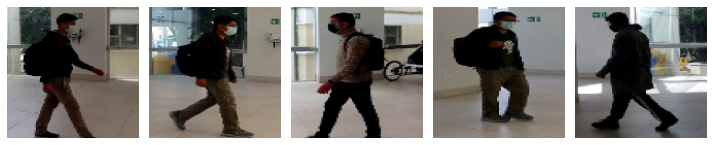

In [73]:
images, masks = next(train_generator)

print(images.shape)
fig, axes = plt.subplots(1, 5, figsize = (10, 10))
axes = axes.flatten()
for img, ax in zip(images, axes):
  ax.imshow(img)
  ax.axis("off")
plt.tight_layout()
plt.show()

(256, 128, 128, 1)


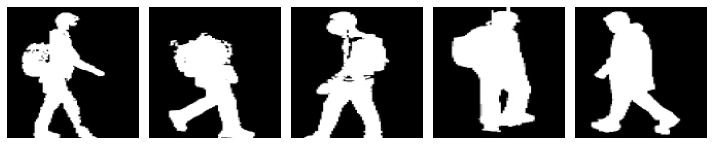

In [74]:
fig, axes = plt.subplots(1, 5, figsize = (10, 10))
print(masks.shape)
axes = axes.flatten()
for msk, ax in zip(masks, axes):
  ax.imshow(np.squeeze(msk), cmap='gray')
  ax.axis("off")
plt.tight_layout()
plt.show()

## Loading the pre-trained model

In [91]:
model_segmentation = tf.keras.models.load_model('/content/128x128_acc_0.9549_loss_0.0886_val-acc_0.9554_val-loss_0.0873_0.22M_01-08-21-DB_UCB300_E_10x1E-4_5x1E-5')

In [92]:
model_segmentation.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_7 (Sequential)      (None, 64, 64, 16)   432         ['input_2[0][0]']                
                                                                                                  
 sequential_8 (Sequential)      (None, 32, 32, 32)   4672        ['sequential_7[0][0]']           
                                                                                                  
 sequential_9 (Sequential)      (None, 16, 16, 64)   18560       ['sequential_8[0][0]']     

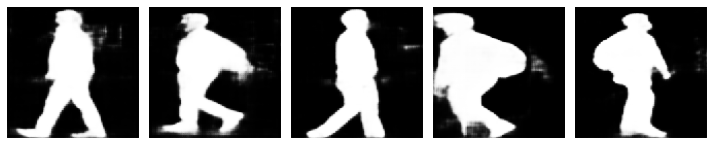

In [93]:
result = model_segmentation(images)
fig, axes = plt.subplots(1, 5, figsize = (10, 10))
axes = axes.flatten()
for res, ax in zip(result, axes):
  ax.imshow(np.squeeze(res),cmap="gray")
  ax.axis("off")
plt.tight_layout()
plt.show()

In [94]:
images, masks = next(val_generator)

model_segmentation.evaluate(images,masks)

8/8 [==============================] - 0s 12ms/step - loss: 0.1809 - accuracy: 0.8267


[0.18094518780708313, 0.8266654014587402]

## Feeding the model with the new data

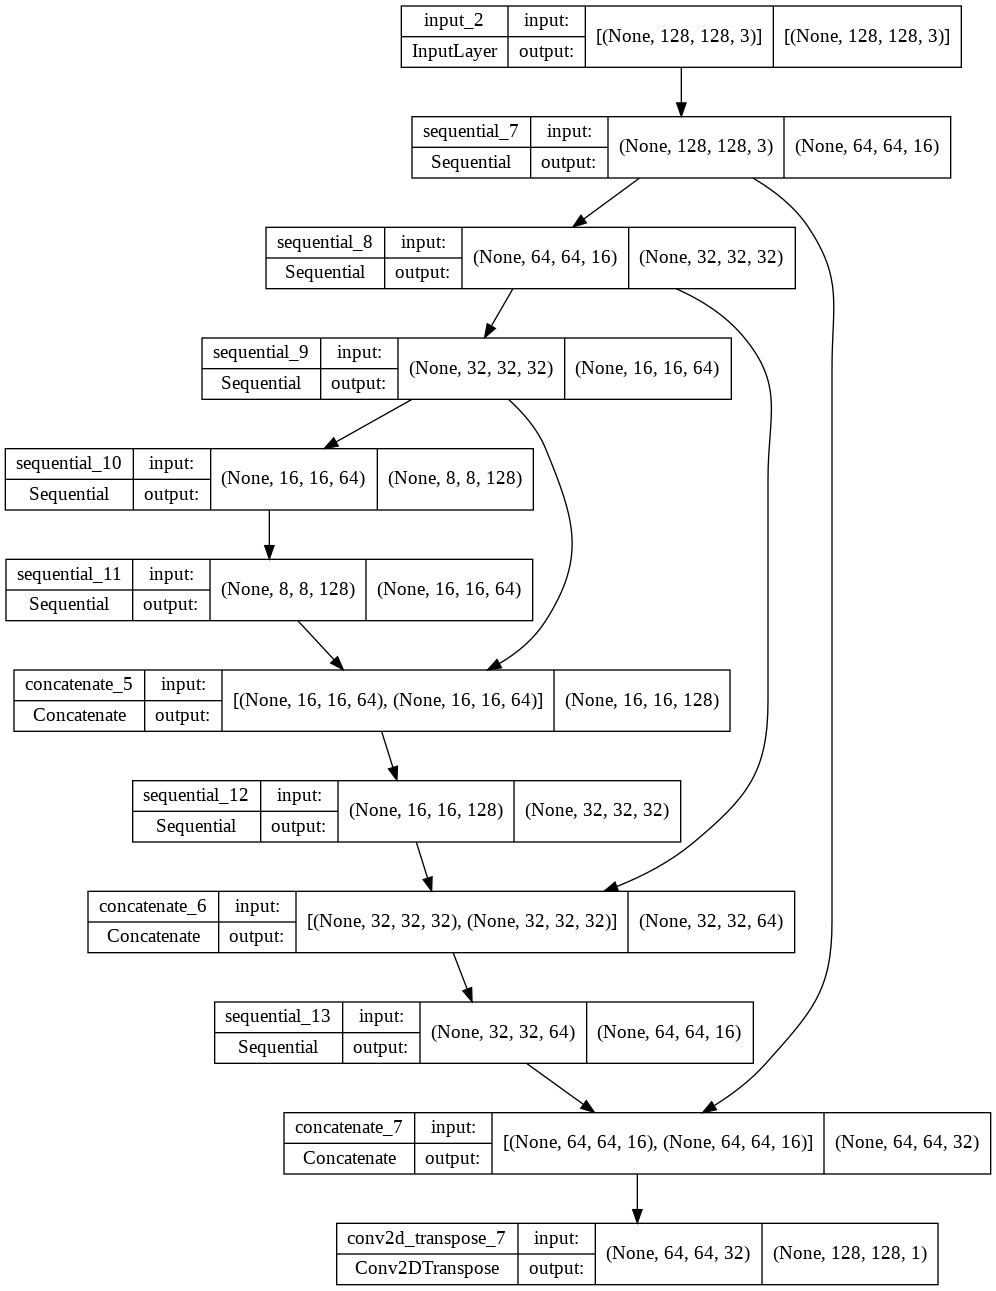

In [95]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam"
)

loss = tf.keras.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    name='binary_crossentropy'
)

model_segmentation.compile(optimizer = optimizer, loss = loss, metrics = ["accuracy"])

tf.keras.utils.plot_model(model_segmentation, show_shapes=True, show_layer_names=True)

In [96]:
callback_early = tf.keras.callbacks.EarlyStopping(monitor = "loss", patience=3, mode = "auto")

In [97]:
training_samples = train_images_generator.n
validation_samples = val_images_generator.n

history_segmentation = model_segmentation.fit(
  train_generator,
  steps_per_epoch=training_samples // batch,
  epochs=50,
  validation_data=val_generator, 
  validation_steps=validation_samples // batch,
  callbacks = [callback_early],
)

Epoch 1/50
166/166 [==============================] - 59s 346ms/step - loss: 0.1351 - accuracy: 0.8281 - val_loss: 0.0837 - val_accuracy: 0.8475
Epoch 2/50
166/166 [==============================] - 55s 330ms/step - loss: 0.1072 - accuracy: 0.8344 - val_loss: 0.0757 - val_accuracy: 0.8489
Epoch 3/50
166/166 [==============================] - 56s 338ms/step - loss: 0.1003 - accuracy: 0.8355 - val_loss: 0.0737 - val_accuracy: 0.8492
Epoch 4/50
166/166 [==============================] - 55s 330ms/step - loss: 0.0961 - accuracy: 0.8362 - val_loss: 0.0723 - val_accuracy: 0.8493
Epoch 5/50
166/166 [==============================] - 56s 340ms/step - loss: 0.0924 - accuracy: 0.8367 - val_loss: 0.0711 - val_accuracy: 0.8493
Epoch 6/50
166/166 [==============================] - 55s 332ms/step - loss: 0.0905 - accuracy: 0.8369 - val_loss: 0.0695 - val_accuracy: 0.8500
Epoch 7/50
166/166 [==============================] - 56s 338ms/step - loss: 0.0874 - accuracy: 0.8374 - val_loss: 0.0719 - val_ac

In [98]:
images, masks = next(val_generator)
model_segmentation.evaluate(images,masks)

8/8 [==============================] - 0s 13ms/step - loss: 0.0654 - accuracy: 0.8483


[0.06539618968963623, 0.8482706546783447]

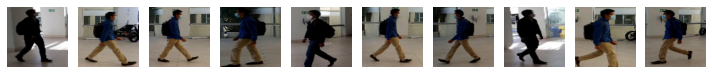

In [99]:
images, masks = next(val_generator)
result = model_segmentation(images)
result = np.squeeze(result)

fig, axes = plt.subplots(1, 10, figsize = (10, 10))
axes = axes.flatten()
for img, ax in zip(images, axes):
  ax.imshow(img)
  ax.axis("off")
plt.tight_layout()
plt.show()

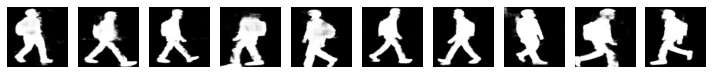

In [100]:
fig, axes = plt.subplots(1, 10, figsize = (10, 10))
axes = axes.flatten()
for res, ax in zip(result, axes):
  ax.imshow(np.squeeze(res),cmap="gray")
  ax.axis("off")
plt.tight_layout()
plt.show()

In [101]:
model_segmentation.save("128x128_acc_0-8408_loss_0-0663_val_acc_0-8485_val_loss_0-0665_DB_UCB300_OAKGait16_0-2M")

In [102]:
!zip -r 128x128_acc_0-8408_loss_0-0663_val_acc_0-8485_val_loss_0-0665_DB_UCB300_OAKGait16_0-2M 128x128_acc_0-8408_loss_0-0663_val_acc_0-8485_val_loss_0-0665_DB_UCB300_OAKGait16_0-2M

  adding: 128x128_acc_0-8408_loss_0-0663_val_acc_0-8485_val_loss_0-0665_DB_UCB300_OAKGait16_0-2M/ (stored 0%)
  adding: 128x128_acc_0-8408_loss_0-0663_val_acc_0-8485_val_loss_0-0665_DB_UCB300_OAKGait16_0-2M/variables/ (stored 0%)
  adding: 128x128_acc_0-8408_loss_0-0663_val_acc_0-8485_val_loss_0-0665_DB_UCB300_OAKGait16_0-2M/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: 128x128_acc_0-8408_loss_0-0663_val_acc_0-8485_val_loss_0-0665_DB_UCB300_OAKGait16_0-2M/variables/variables.index (deflated 71%)
  adding: 128x128_acc_0-8408_loss_0-0663_val_acc_0-8485_val_loss_0-0665_DB_UCB300_OAKGait16_0-2M/keras_metadata.pb (deflated 93%)
  adding: 128x128_acc_0-8408_loss_0-0663_val_acc_0-8485_val_loss_0-0665_DB_UCB300_OAKGait16_0-2M/saved_model.pb (deflated 90%)
  adding: 128x128_acc_0-8408_loss_0-0663_val_acc_0-8485_val_loss_0-0665_DB_UCB300_OAKGait16_0-2M/assets/ (stored 0%)
